# PyCUBOとOpenjijの連携

本稿では，PyQUBOによるコスト関数のQUBOへの変換方法とSimulated Annealing，OpenJijへの変数受け渡しなど についてクリーク被覆問題を例に説明する

In [2]:
# 必要なライブラリをインポート
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
import random

参考ページ

https://qard.is.tohoku.ac.jp/T-Wave/?p=434

In [3]:
#PyQUBO
from pyqubo import Array, Binary, Constraint, Placeholder, solve_qubo
import openjij as oj

## クリーク被覆問題とは？

https://ja.wikipedia.org/wiki/%E6%9C%80%E5%B0%8F%E3%82%AF%E3%83%AA%E3%83%BC%E3%82%AF%E8%A2%AB%E8%A6%86%E5%95%8F%E9%A1%8C

## 配列を作成する際の例

In [4]:
#shape=4で4つの1次元配列をつくる。
x_1d = Array.create('x', shape=4, vartype='BINARY')
print(x_1d)
print()
for x in x_1d:
    print(x.label, x.structure)
print()
print(x_1d.shape)

Array([Binary(x[0]), Binary(x[1]), Binary(x[2]), Binary(x[3])])

x[0] {'x[0]': ('x', 0)}
x[1] {'x[1]': ('x', 1)}
x[2] {'x[2]': ('x', 2)}
x[3] {'x[3]': ('x', 3)}

(4,)


In [5]:
#２次元配列を作る
x_2d = Array.create('x', shape=(2, 2), vartype='BINARY')
print(x_2d)
print(x_2d.shape)

Array([[Binary(x[0][0]), Binary(x[0][1])],
       [Binary(x[1][0]), Binary(x[1][1])]])
(2, 2)


 shape=(2, 2)で2×2の上記のような2次元配列を作っている。

PyQUBOのみによるクリーク被覆問題の方法を説明する．

***PyQUBOによるSimulated Annealing***
ここから，実際にPyQUBOを用いて最適化問題をSAで解く方法を説明していく．
まずコスト関数をQUBOに変換する方法を紹介する．ここではクリーク被覆問題を例に説明する．

まず，PyQUBOをimport．

今回はクリーク被覆問題の初期条件を以下のように与える．

In [6]:
#頂点の数
N_VER = 8
#色の数
N_COLOR = 4
#グラフを定義．0~7とうい名前の頂点があったときに，どの頂点同士が線で結ばれているかを定義している．
graph = [(0,1), (0,2), (1,3), (5,6), (2,3), (2,5), (3,4), (5,7)]

networkx でグラフの可視化

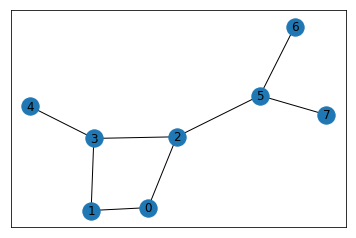

In [7]:
G=nx.Graph()
G.add_edges_from(graph)
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos)
plt.show()

`PyQUBO(N_VER,N_COLOR,graph)` という，PyQUBOを用いてSAした結果を返す関数を定義する．

ここからは，PyQUBO関数の中身について説明していく．

まず，コスト関数に用いるxを以下のように定義．

In [8]:
# BINARY変数 PyQUBOでは，以下のようにArray.createとう関数で配列を作ることができる．
x = Array.create('x', shape=(N_VER,N_VER), vartype='BINARY')

次に，最小化項とペナルティ項を以下のように打ち込み，コスト関数を定義する．
通常のQUBOを作成する方法とはことなり，式をそのまま直感的に打つこむことができる．


In [9]:
#最小化項        
H_A = sum((1-sum(x[v,i] for i in range(1,N_COLOR)))**2 for v in range(N_VER))
#ペナルティ項
H_B = sum((-1+sum(x[v,i] for v in range (N_VER)))/2*(sum(x[v,i] for v in range (N_VER))) - sum(x[u,i]*x[v,i] for (u,v) in graph) for i in range (1,N_COLOR))

#コスト関数
Q = H_A+H_B

作成したコスト関数は，以下のように`Q.compile().to_qubo()` で簡単にQUBOに変換することができる．

In [10]:
# モデルをコンパイル
model = Q.compile()
qubo, offset = model.to_qubo()

PyQUBOによってSimulated Annealingするには，
`solve_qubo(qubo)`を用いる．

In [11]:
#PyQUBOによるSA
raw_solution = solve_qubo(qubo)

# 結果の表示
print(raw_solution)

{'x[0][1]': 0, 'x[0][2]': 0, 'x[0][3]': 1, 'x[1][1]': 0, 'x[1][2]': 0, 'x[1][3]': 1, 'x[2][1]': 1, 'x[2][2]': 0, 'x[2][3]': 0, 'x[3][1]': 0, 'x[3][2]': 1, 'x[3][3]': 0, 'x[4][1]': 0, 'x[4][2]': 1, 'x[4][3]': 0, 'x[5][1]': 1, 'x[5][2]': 0, 'x[5][3]': 0, 'x[6][1]': 0, 'x[6][2]': 0, 'x[6][3]': 0, 'x[7][1]': 0, 'x[7][2]': 0, 'x[7][3]': 0}


In [12]:
# 得られた結果をデコードする
decoded_solution, broken, energy = model.decode_solution(raw_solution, vartype="BINARY")
print("decoded_solution", decoded_solution)
print("broken", broken)
print("energy", energy)

decoded_solution {'x': {0: {1: 0, 2: 0, 3: 1}, 1: {1: 0, 2: 0, 3: 1}, 2: {1: 1, 2: 0, 3: 0}, 3: {1: 0, 2: 1, 3: 0}, 4: {1: 0, 2: 1, 3: 0}, 5: {1: 1, 2: 0, 3: 0}, 6: {1: 0, 2: 0, 3: 0}, 7: {1: 0, 2: 0, 3: 0}}}
broken {}
energy 2.0


In [13]:
hex(random.randint(0, (2**4)**3-1))

'0xe74'

rgb #0eb233
group [6, 7]
rgb #e1878e
group [2, 5]
rgb #f79ff0
group [3, 4]
rgb #bc5709
group [0, 1]


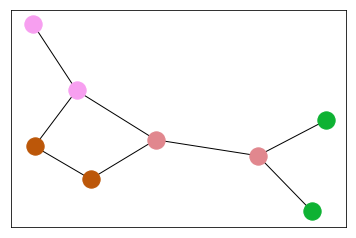

In [41]:
def show_result_graph(G1, N_COLOR, decoded_solution):
    pos1= nx.spring_layout(G1, k= 0.3 ) # positions for all nodes

    for ii in range(0, N_COLOR):
        group = []
        color = "#" + "{0:06x}".format(random.randint(0, 256**3-1))
        print("rgb",color)
        if ii == 0:
            for idx, label in decoded_solution["x"].items():
                if sum(label.values())<1:
                    group.append(idx)
        else:
            for idx, label in decoded_solution["x"].items():
                if label[ii]== 1:
                    group.append(idx)
        print("group",group)
        nx.draw_networkx_nodes(G1, pos1,
                               nodelist=group,
                               node_color=color)
    nx.draw_networkx_edges(G1, pos1, width=1.0, alpha=1)
    plt.show()
    
show_result_graph(G, N_COLOR, decoded_solution)

***PyQUBOによってQUBOに変換したモデルのOpenJijによる評価***
次に，上のコードに追記する形で，OpenJijにQUBOを受け渡し，SQAで解く方法を以下で紹介する．
まずPyQUBO関数の中で，QUBOも返すように変更する．
   ` return qubo,decoded_solution`

そして，関数の外で，以下のようにQUBOを受け渡すことでOpenJijによる評価ができるようになる．

In [74]:
import openjij as oj

In [82]:
#openjijのSQASamplerにに渡す
sampler = oj.SQASampler(iteration=10, step_num=100)
response = sampler.sample_qubo(qubo)
#結果を出力．
print(response.states)
print(len(response.states))


[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0], [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0], [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0], [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0], [0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1], [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0], [0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1], [0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0], [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]]
10


まとめると，以下のようになる．

In [21]:
# coding: utf-8
#openJijを使用。
import openjij as oj
#PyQUBO
from pyqubo import Array, Constraint, Placeholder, solve_qubo

#頂点の数
N_VER = 8
#色の数
N_COLOR = 3
graph = [(0,1), (0,2), (1,3), (5,6), (2,3), (2,5), (3,4), (5,7)]
def PyQUBO(N_VER,N_COLOR,graph):
    #イジング変数の数
    N = N_VER * N_COLOR
    # BINARY変数
    x = Array.create('x', shape=(N_VER,N_VER), vartype='BINARY')
    #最小化項        
    H_A = sum((1-sum(x[v,i] for i in range(1,N_COLOR)))**2 for v in range(N_VER))
    #ペナルティ項
    H_B = sum((-1+sum(x[v,i] for v in range (N_VER)))/2*(sum(x[v,i] for v in range (N_VER))) - sum(x[u,i]*x[v,i] for (u,v) in graph) for i in range (1,N_COLOR))
    #コスト関数
    Q = H_A+H_B 
    
    # モデルをコンパイル
    model = Q.compile()
    qubo, offset = model.to_qubo()
    
    #PyQUBOによるSA
    raw_solution = solve_qubo(qubo)
    # 得られた結果をデコードする
    decoded_solution, broken, energy = model.decode_solution(raw_solution, vartype="BINARY")
    #ここでQUBOも返すように変更する．
    return qubo,decoded_solution
    

Q,resultPyQUBO = PyQUBO(N_VER,N_COLOR,graph)
sampler = oj.SASampler(iteration=10, step_num=100)
response = sampler.sample_qubo(Q)

#PyQUBOによるSAの結果出力
#print(resultPyQUBO)

#OpenJijによるSQAの結果出力
print(response.states)

[[1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0], [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1], [0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1], [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0], [0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0], [0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0]]


参考：PyQUBO公式ドキュメント
https://pyqubo.readthedocs.io/en/latest/reference/array.html?highlight=arry%20create

※余談として，.pyipynbは.pyファイルに以下のように変換できるよう．
`$ jupyter nbconvert --to script [YOUR_NOTEBOOK].ipynb`